In [ ]:
# Description: This program will predict the stock for a specific day using Neural Network

In [ ]:
!pip install yfinance


In [68]:
# Import libaries
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

In [69]:
ticker = "AAPL";

# Get data from yahoo finance
df = yf.download(ticker, start="2012-01-01", end="2020-01-01")#end=dt.datetime.today().strftime('%Y-%m-%d'))
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.650659,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.718646,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.859850,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.994284,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.973674,394024400
...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,70.353882,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,71.749733,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,71.722488,146266000


In [70]:
# Prepare the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Lower number = More accurate local (short term), higher = More accurate global (longterm)
prediction_days = 60

x_train = []
y_train = []

for i in range(prediction_days, len(scaled_data)):
  x_train.append(scaled_data[i - prediction_days : i, 0])
  y_train.append(scaled_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [78]:
# Build the model
model = Sequential()

# Adjust the units base on the amount of layers in the NN
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')
# Model will see the data 24 times and 32 units it wants
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
61/61 [==============================] - 7s 55ms/step - loss: 0.0349
Epoch 2/25
61/61 [==============================] - 3s 57ms/step - loss: 0.0025
Epoch 3/25
61/61 [==============================] - 3s 56ms/step - loss: 0.0024
Epoch 4/25
61/61 [==============================] - 3s 57ms/step - loss: 0.0021
Epoch 5/25
61/61 [==============================] - 4s 57ms/step - loss: 0.0017
Epoch 6/25
61/61 [==============================] - 4s 58ms/step - loss: 0.0018
Epoch 7/25
61/61 [==============================] - 4s 58ms/step - loss: 0.0020
Epoch 8/25
61/61 [==============================] - 4s 58ms/step - loss: 0.0015
Epoch 9/25
61/61 [==============================] - 4s 58ms/step - loss: 0.0014
Epoch 10/25
61/61 [==============================] - 4s 59ms/step - loss: 0.0015
Epoch 11/25
61/61 [==============================] - 4s 58ms/step - loss: 0.0013
Epoch 12/25
61/61 [==============================] - 4s 59ms/step - loss: 0.0012
Epoch 13/25
61/61 [==================

In [79]:
# Get the actual price to test
df_test = yf.download(ticker, start="2020-01-01", end=dt.datetime.today().strftime('%Y-%m-%d'))
actual_price = df_test['Close'].values

# Load the test data into the model
total_dataset = pd.concat((df['Close'], df_test['Close']), axis=0)
model_inputs = total_dataset[len(total_dataset) - len(df_test) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


In [80]:
# Test the accuracy of the model
x_test = []

for i in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[i - prediction_days : i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

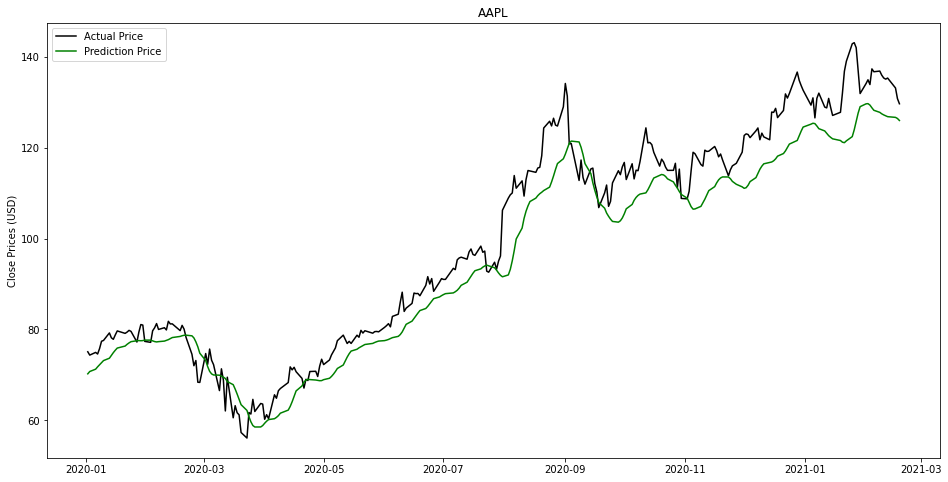

In [81]:
# Plot the test predictions
plt.figure(figsize=(16,8))
plt.plot(df_test.index, actual_price, color="black", label="Actual Price")
plt.plot(df_test.index, predicted_prices, color="green", label="Prediction Price")
plt.title(f"{ticker}")
plt.ylabel("Close Prices (USD)")
plt.legend()
plt.show()

In [83]:
# Predict Next Day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days : len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction Price for {dt.date.today() + dt.timedelta(days=1)} is {prediction[0]}")

Prediction Price for 2021-02-20 is [125.383484]
